# SNN Test


In [29]:
import sys
import snntorch as snn
from snntorch import spikeplot as split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Module
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import itertools

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Numpy version', np.__version__)
print("env path: ", sys.executable) 

#[+] check to see if gpu is available, else use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Using device: ',device)
for i in range(torch.cuda.device_count()): print('       -->',i,':', torch.cuda.get_device_name(i))

System Version: 3.13.0 (main, Oct  7 2024, 05:02:14) [Clang 15.0.0 (clang-1500.3.9.4)]
PyTorch version 2.7.1
Numpy version 2.2.6
env path:  /Users/pranmodu/Documents/GitHub/perceptrons-neuromatch/.venv/bin/python
Using device:  cpu


## DataLoading MNIST

In [30]:
batch_size= 128
data_path= r'./data'
dtype= torch.float

# Create the transoform for MNIST dataset to make sure its 28x28, grayscale, a tensor, and vals normalized to fall between 0 and 1
transform= transforms.Compose([
    transforms.Resize((28,28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,)),])

# Automatically downloads and splits the MNIST dataset
mnist_train = datasets.MNIST(data_path, train= True , download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train= False, download=True, transform=transform)

#create DataLoaders
train_loader= DataLoader(mnist_train , batch_size= batch_size, shuffle=True, drop_last=True)
test_loader= DataLoader(mnist_test , batch_size= batch_size, shuffle=True, drop_last=True)

# Construct a Fully Connected SNN Architecture

In [31]:
# Number of inputs should match number of pixels in the MNIST img
num_inputs= 28*28  #= 784

# Hidden layer is however big you want as long as it fits in your GPU
num_hidden= 1000

# One output neuron for each of the 10 MNIST digits
num_outputs= 10

# 25 time steps is a quick simulation
num_steps= 25

# Rate of decay
beta= 0.95

In [32]:
class Snn(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs, beta):
        super().__init__()
        
        # Initialize layers before defining the forward function
        self.fc1 = nn.Linear(num_inputs, num_hidden) 
        self.lif1 = snn.Leaky(beta=beta)

        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)
        

    def forward(self, x):
        # init hidden states at t=0, mem is membrane potential
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # [+] Record the hidden layer
        spk1_rec = []
        mem1_rec = []

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            # x.shape: torch.Size([128, 784]) -> 128=batch_size, 784= 28x28 img; x is a batch of 128 images

            # cur1 , spk1, mem1 shape:  torch.Size([128, 1000]) torch.Size([128, 1000]) torch.Size([128, 1000])
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            
            # cur2 , spk2, mem2 shape:  torch.Size([128, 10]) torch.Size([128, 10]) torch.Size([128, 10])
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            
            # [+] store hidden layer in list
            spk1_rec.append(spk1)
            mem1_rec.append(mem1)

            # stor final layer in list
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        # rec stack sizes:  torch.Size([25, 128, 10]) torch.Size([25, 128, 10])
        spk_stack, mem_stack= torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        spk_stack_hid, mem_stack_hid= torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0)

        # The network returns a tensor of spike recordings over time, and a tensor of membrane potential recordnigs over time
        return spk_stack, mem_stack, spk_stack_hid, mem_stack_hid

        
# Load the network onto CUDA if available
snn_loaded = Snn(num_inputs, num_hidden, num_outputs, beta).to(device)

## Training

In [33]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(snn_loaded.parameters(), lr=5e-4, betas=(0.9, 0.999))

# # 60000 data samples / 128 samples per batch = approx 468 iterations
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0
cntLim= 100
saveMdl= False

# Outer training loop
for epoch in range(num_epochs):
    train_batch = iter(train_loader)

    # Minibatch training loop: each batch will have data which is the 128 samples, and each sample will have target labels (digits 0-9), we load all into cuda
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        #forward pass: we set our network to train mode, and pass the data into it
        snn_loaded.train()
        spk_rec, mem_rec, _, _ = snn_loaded(data.flatten(1))
        #spk_rec and mem_rec sizes:  torch.Size([25, 128, 10]) 

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val += loss(spk_rec.sum(0), targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print train/test loss/accuracy
        if counter % 10 == 0:
            print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
        counter += 1

        if counter == cntLim:
            if(saveMdl):
                torch.save(snn_loaded.state_dict(), 'snn_mdl.pth')
                print(' -->[+] model saved')
            else: print('   -->[x] no save')
            break

Iteration: 0 	 Train Loss: 2.3991646766662598
Iteration: 10 	 Train Loss: 1.115999698638916
Iteration: 20 	 Train Loss: 1.0766109228134155
Iteration: 30 	 Train Loss: 0.9501477479934692
Iteration: 40 	 Train Loss: 0.5177742838859558
Iteration: 50 	 Train Loss: 0.3782593011856079
Iteration: 60 	 Train Loss: 0.3359973728656769
Iteration: 70 	 Train Loss: 0.2405940592288971
Iteration: 80 	 Train Loss: 0.3627702295780182
Iteration: 90 	 Train Loss: 0.25255274772644043
   -->[x] no save


## Test Accuracy

In [34]:
def measure_accuracy(model, dataloader):
  with torch.no_grad():
    model.eval()
    running_length = 0
    running_accuracy = 0

    for data, targets in iter(dataloader):
      # data shape:  torch.Size([128, 1, 28, 28])
      data = data.to(device)
      targets = targets.to(device)

      # flat data shape:  torch.Size([128, 784]) -> a batch of 28x28 imsg is flattened to a batch of 1x784 along dim 1
      data= data.flatten(1)

      # spk_rec, mem_rec = model(data)
      spk_rec, mem_rec, spk_stack_hid, mem_stack_hid = model(data)
      
      spike_count = spk_rec.sum(0)
      _, max_spike = spike_count.max(1)

      # correct classes for one batch
      num_correct = (max_spike == targets).sum()

      # total accuracy
      running_length += len(targets)
      running_accuracy += num_correct
    
    accuracy = (running_accuracy / running_length)

    return accuracy.item(), spk_rec, mem_rec, spk_stack_hid, mem_stack_hid

In [35]:

accuracy, spk_rec, mem_rec, spk_stack_hid, mem_stack_hid= measure_accuracy(snn_loaded, test_loader)
print('spk_rec: ', spk_rec.shape,'\n', spk_rec[num_steps-1][0],'\n')
print('mem_rec: ', mem_rec.shape,'\n',mem_rec[num_steps-1][0],'\n')
print('spk_stack_hid: ', spk_stack_hid.shape,'\n', spk_stack_hid[num_steps-1][0],'\n')
print('mem_stack_hid: ', mem_stack_hid.shape,'\n',mem_stack_hid[num_steps-1][0],'\n')
print( 'Accuracy: ', accuracy)


spk_rec:  torch.Size([25, 128, 10]) 
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]) 

mem_rec:  torch.Size([25, 128, 10]) 
 tensor([-2.0973, -2.8079,  0.1512, -4.1518,  0.5091, -2.9413, -1.8614,  0.6811,
         0.3834,  1.1300]) 

spk_stack_hid:  torch.Size([25, 128, 1000]) 
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

## Representational Dissimilarity Matrices

In [36]:
import torch
from torchvision.models import resnet50
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork

In [37]:
import rsatoolbox
from rsatoolbox.data import Dataset
from rsatoolbox.rdm.calc import calc_rdm

Helper functions from W1D3 Tutorial

In [61]:
def get_sample_images_ordered(test_loader, n_samples=100, samples_per_class=None):

    # structure as:
    # class 1 sample 1, class 1 sample 2, ...
    # class 2 sample 1, ...
    # ...
    # class 10 sample 1, ...

    # For MNIST, we have 10 classes (0-9)
    num_classes = 10

    # Calculate samples per class
    if samples_per_class is None:
        samples_per_class = n_samples // num_classes

    # Adjust total samples to ensure even distribution
    actual_n_samples = samples_per_class * num_classes

    print(f"Collecting {samples_per_class} samples per class ({actual_n_samples} total)")

    # Collect images by class
    class_images = {i: [] for i in range(num_classes)}
    class_labels = {i: [] for i in range(num_classes)}

    # Collect images from dataloader
    for batch_imgs, batch_labels in test_loader:
        for img, label in zip(batch_imgs, batch_labels):
            label_int = label.item()

            # Only collect if we haven't reached the limit for this class
            if len(class_images[label_int]) < samples_per_class:
                class_images[label_int].append(img.unsqueeze(0))
                class_labels[label_int].append(label.unsqueeze(0))

        # Check if we have enough samples for all classes
        if all(len(class_images[i]) >= samples_per_class for i in range(num_classes)):
            break


    ordered_imgs = []
    ordered_labels = []

    for class_idx in range(num_classes):
        # Take exactly samples_per_class for each class
        class_imgs = class_images[class_idx][:samples_per_class]
        class_lbls = class_labels[class_idx][:samples_per_class]

        ordered_imgs.extend(class_imgs)
        ordered_labels.extend(class_lbls)


    final_imgs = torch.cat(ordered_imgs)
    final_labels = torch.cat(ordered_labels)


    return final_imgs, final_labels

def calc_rdms(model_features, method='correlation'):
    """
    Calculates representational dissimilarity matrices (RDMs) for model features.

    Inputs:
    - model_features (dict): A dictionary where keys are layer names and values are features of the layers.
    - method (str): The method to calculate RDMs, e.g., 'correlation' is pearson, 'euclidean', 'spearman', 'cosine'

    Outputs:
    - rdms (pyrsa.rdm.RDMs): RDMs object containing dissimilarity matrices.
    - rdms_dict (dict): A dictionary with layer names as keys and their corresponding RDMs as values.
    """
    ds_list = []
    for l in range(len(model_features)):
        layer = list(model_features.keys())[l]
        feats = model_features[layer]

        if type(feats) is list:
            feats = feats[-1]


        feats = feats.cpu()

        if len(feats.shape) > 2:
            feats = feats.flatten(1)

        feats = feats.detach().numpy()
        ds = Dataset(feats, descriptors=dict(layer=layer))
        ds_list.append(ds)

    rdms = calc_rdm(ds_list, method=method)
    rdms_dict = {list(model_features.keys())[i]: rdms.get_matrices()[i] for i in range(len(model_features))}

    return rdms, rdms_dict

def plot_rdms(rdms_dict, figsize_per_plot=(3.5, 3), cmap='viridis'):
    """
    Plot RDMs for visualization

    Args:
        rdms_dict: Dictionary of RDMs by layer name
        figsize_per_plot: Size of each subplot
        cmap: Colormap for visualization

    revise so all subplots share the same color scale (legend range) based on the global min and max across all RDMs
    """

    n_layers = len(rdms_dict)
    cols = min(3, n_layers)  # Max 3 columns
    rows = (n_layers + cols - 1) // cols  # Ceiling division

    fig, axes = plt.subplots(rows, cols,
                            figsize=(cols * figsize_per_plot[0], rows * figsize_per_plot[1]))

    if n_layers == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    else:
        axes = axes.flatten()

    # Compute global vmin and vmax across all RDMs
    all_values = np.concatenate([rdm.flatten() for rdm in rdms_dict.values()])

    for idx, (layer_name, rdm) in enumerate(rdms_dict.items()):
        ax = axes[idx]

        # Plot RDM
        im = ax.imshow(rdm, cmap=cmap, aspect='auto', vmin=-1.5, vmax=1.5)
        ax.set_title(f'{layer_name}\n({rdm.shape[0]}×{rdm.shape[1]})')
        ax.set_xlabel('Stimulus')
        ax.set_ylabel('Stimulus')

        # Add colorbar
        plt.colorbar(im, ax=ax, shrink=0.8)

    # Hide empty subplots
    for idx in range(n_layers, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.suptitle('Representational Dissimilarity Matrices (RDMs)',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.show()


In [39]:
def extract_features(model, imgs, return_layers, plot='none'):
    """
    Extracts features from specified layers of the model using forward hooks.
    This version is designed to work with SNNs that have internal time-stepping loops.

    Inputs:
    - model (torch.nn.Module): The model from which to extract features.
    - imgs (torch.Tensor): Batch of input images.
    - return_layers (list): List of *module names* (strings) from which to extract features.
                            For SNNs, these are names like 'fc1', 'lif1', 'fc2', 'lif2'.
                            'all' or 'layers' options are adapted to use model.named_modules()
                            since get_graph_node_names will fail on this SNN.
    - plot (str): Option to plot the features. Default is 'none'. (Currently not implemented here).

    Outputs:
    - model_features (dict): A dictionary with layer names as keys and extracted features as values.
                             For SNNs with internal loops, features for each layer will be a tensor
                             of shape (time_steps, batch_size, features) or (time_steps, batch_size, height, width, channels).

    """

    activations = {name: [] for name in return_layers}

    # hook function
    def save_activation(name):
        def hook(module, input, output):
            if isinstance(output, tuple) and len(output) == 2:
                activations[name].append(output[0].detach().cpu())
                if f"{name}_mem" in activations: # Check if mem key exists
                    activations[f"{name}_mem"].append(output[1].detach().cpu())
            else:
                activations[name].append(output.detach().cpu())
        return hook

    # register hook handles
    hook_handles = []
    for name, module in model.named_modules():
        if name in return_layers:
            handle = module.register_forward_hook(save_activation(name))
            hook_handles.append(handle)

    # perform a forward pass - this will trigger the hooks for each time step within the SNN's forward loop.
    print(f"Executing forward pass on {model.__class__.__name__} to extract features...")
    with torch.no_grad(): 
        model(imgs)

    # remove hooks 
    for handle in hook_handles:
        handle.remove()
    print("Forward hooks removed.")

    # process collected activations
    stacked_features = {}
    for name, data_list in activations.items():
        stacked_features[name] = torch.stack(data_list, dim=0)

    return stacked_features, activations

In [40]:
print(snn_loaded)

Snn(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
  (lif2): Leaky()
)


In [41]:
layers_to_extract = ['fc1', 'lif1', 'fc2', 'lif2']

imgs, labels =  get_sample_images_ordered(test_loader, samples_per_class=30) # extract 15 images from each category, totally 150 images
imgs_flattened = imgs.view(imgs.size(0), -1).to(device)

snn_features, activations = extract_features(snn_loaded, imgs_flattened, return_layers=layers_to_extract)

Executing forward pass on Snn to extract features...
Forward hooks removed.


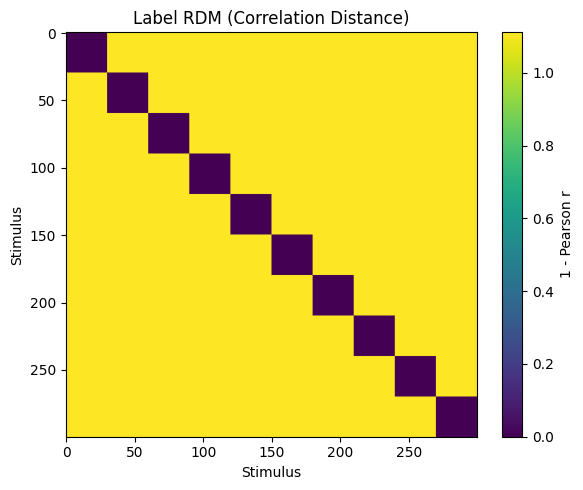

In [42]:
import torch
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

def compute_label_rdm_correlation(labels):
    """
    Compute a correlation-distance RDM from one-hot encoded labels.
    Equivalent to how feature RDMs are calculated.

    Args:
        labels (torch.Tensor or np.ndarray): Class labels (N,)

    Returns:
        label_rdm (np.ndarray): RDM of shape (N, N)
    """
    labels_np = labels.cpu().numpy() if torch.is_tensor(labels) else labels
    labels_np = labels_np.reshape(-1, 1)

    # One-hot encode labels
    encoder = OneHotEncoder(sparse_output=False, categories='auto')
    labels_onehot = encoder.fit_transform(labels_np)

    # Compute Pearson correlation distance: 1 - r
    label_rdm = squareform(pdist(labels_onehot, metric='correlation'))
    return label_rdm

def plot_label_rdm(label_rdm, title='Label RDM (Correlation Distance)', figsize=(6, 5), cmap='viridis'):
    plt.figure(figsize=figsize)
    plt.imshow(label_rdm, cmap=cmap, aspect='auto')
    plt.title(title)
    plt.xlabel('Stimulus')
    plt.ylabel('Stimulus')
    plt.colorbar(label='1 - Pearson r')
    plt.tight_layout()
    plt.show()

# Usage
label_rdm_corr = compute_label_rdm_correlation(labels)
plot_label_rdm(label_rdm_corr)

In [43]:
snn_features['fc1'].shape
# (layer, timestep, image, hidden layer)

torch.Size([25, 300, 1000])

In [44]:
activations['fc1'][0].shape
# (layer, timestep, image, hidden layer)

torch.Size([300, 1000])

In [46]:
i = 24
activations_per_timestep = {}
for layer in layers_to_extract:
    activations_per_timestep[layer] = activations[layer][i]

/Users/pranmodu/Documents/GitHub/perceptrons-neuromatch/.venv/lib/python3.13/site-packages/rsatoolbox/rdm/calc.py:237: RuntimeWarning: invalid value encountered in divide
  ma /= np.sqrt(np.einsum('ij,ij->i', ma, ma))[:, None]


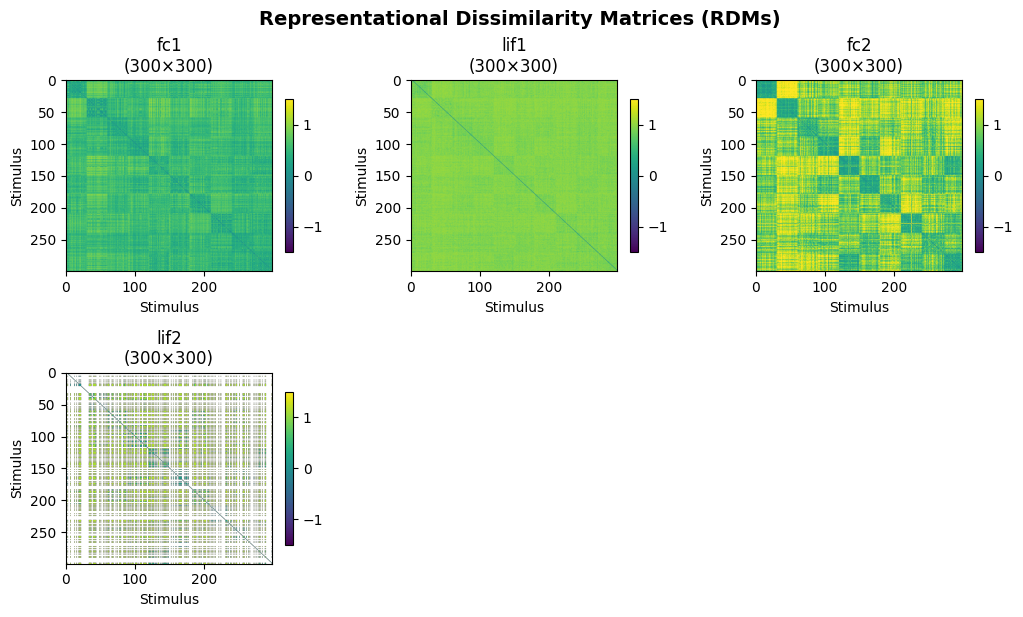

In [62]:
rdms, rdms_dict = calc_rdms(activations_per_timestep, method='correlation')
plot_rdms(rdms_dict)

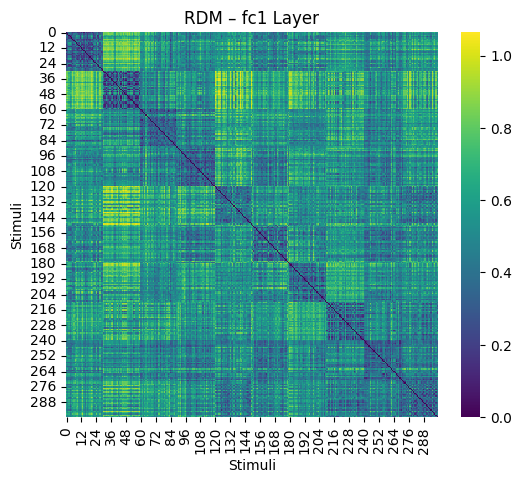

In [48]:
import seaborn as sns

fc1_rdm = rdms_dict['fc1']
plt.figure(figsize=(6,5))
sns.heatmap(fc1_rdm, cmap='viridis')
plt.title("RDM – fc1 Layer")
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")
plt.show()

## Representational Similarity Analysis

In [49]:
import rsatoolbox as rsa
from sklearn.decomposition import PCA
from sklearn import manifold
import matplotlib as mpl

### Calculate RSA manually

In [50]:
from scipy.stats import spearmanr
assert fc1_rdm.shape == label_rdm_corr.shape, "RDMs must be same size"

# Get upper triangle (excluding diagonal)
def get_upper_triangle(rdm):
    return rdm[np.triu_indices_from(rdm, k=1)]

fc1_vec = get_upper_triangle(fc1_rdm)
label_vec   = get_upper_triangle(label_rdm_corr)

# Compute Spearman correlation
rho, pval = spearmanr(fc1_vec, label_vec)

print("Spearman rho:", rho)
print("p-value:", pval)

Spearman rho: 0.33262803843087124
p-value: 0.0


In [51]:
from scipy.stats import pearsonr
import numpy as np

assert fc1_rdm.shape == label_rdm_corr.shape, "RDMs must be same size"

# Get upper triangle (excluding diagonal)
def get_upper_triangle(rdm):
    return rdm[np.triu_indices_from(rdm, k=1)]

fc1_vec = get_upper_triangle(fc1_rdm)
label_vec   = get_upper_triangle(label_rdm_corr)

# Compute Pearson correlation
r, pval = pearsonr(fc1_vec, label_vec)

print("Pearson r:", r)
print("p-value:", pval)

Pearson r: 0.3656810975342054
p-value: 0.0


In [52]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Helper: get upper triangle of RDM (vector form)
def get_upper_triangle(rdm):
    return rdm[np.triu_indices_from(rdm, k=1)]

# Get vector representations
fc1_vec = get_upper_triangle(fc1_rdm)
label_vec   = get_upper_triangle(label_rdm_corr)

# Normalize (optional but common)
fc1_vec = fc1_vec - np.mean(fc1_vec)
label_vec = label_vec - np.mean(label_vec)

# Compute cosine similarity between 1D vectors
cos_sim = cosine_similarity(fc1_vec.reshape(1, -1), label_vec.reshape(1, -1))[0, 0]

print("Cosine similarity between fc1 RDM and label RDM:", cos_sim)

Cosine similarity between fc1 RDM and label RDM: 0.3656810975342135


### Calculate RSA across layers

In [53]:
def rep_path(model_features, model_colors, labels=None, rdm_calc_method='correlation', rdm_comp_method='cosine'):
    """
    Represents paths of model features in a reduced-dimensional space.

    Inputs:
    - model_features (dict): Dictionary containing model features for each model.
    - model_colors (dict): Dictionary mapping model names to colors for visualization.
    - labels (array-like, optional): Array of labels corresponding to the model features.
    - rdm_calc_method (str, optional): Method for calculating RDMS ('euclidean' or 'correlation').
    - rdm_comp_method (str, optional): Method for comparing RDMS ('cosine' or 'corr' or 'spearman').
    """
    # with plt.xkcd():
    path_len = []
    path_colors = []
    rdms_list = []
    ax_ticks = []
    tick_colors = []
    model_names = list(model_features.keys())
    
    for m in range(len(model_names)):
        model_name = model_names[m]
        features = model_features[model_name]
        path_colors.append(model_colors[model_name])
        path_len.append(len(features))
        ax_ticks.append(list(features.keys()))
        tick_colors.append([model_colors[model_name]]*len(features))
        rdms, _ = calc_rdms(features, method=rdm_calc_method)
        rdms_list.append(rdms)

    path_len = np.insert(np.cumsum(path_len),0,0)

    if labels is not None:
        rdms, _ = calc_rdms({'labels' : F.one_hot(labels).float().to(device)}, method=rdm_calc_method)
        rdms_list.append(rdms)
        ax_ticks.append(['labels'])
        tick_colors.append(['m'])
        idx_labels = -1

    rdms = rsatoolbox.rdm.concat(rdms_list)

    #Flatten the list
    ax_ticks = [l for model_layers in ax_ticks for l in model_layers]
    tick_colors = [l for model_layers in tick_colors for l in model_layers]
    tick_colors = ['k' if tick == 'input' else color for tick, color in zip(ax_ticks, tick_colors)]
    if rdm_comp_method == 'spearman':
        rdm_vectors = rdms.get_vectors()
        num_rdms = rdm_vectors.shape[0]
        rdms_comp = np.zeros((num_rdms, num_rdms))

        for i in range(num_rdms):
            for j in range(i, num_rdms):
                rho, _ = spearmanr(rdm_vectors[i], rdm_vectors[j])
                rdms_comp[i, j] = rho
                rdms_comp[j, i] = rho

        rdms_comp = 1 - rdms_comp  # convert similarity to dissimilarity

    elif rdm_comp_method == 'corr':
        rdm_vectors = rdms.get_vectors()
        correlation_matrix = np.corrcoef(rdm_vectors)
        rdms_comp = 1 - correlation_matrix # convert similarity to dissimilarity

    else: 
        rdms_comp = rsatoolbox.rdm.compare(rdms, rdms, method=rdm_comp_method)
        if rdm_comp_method == 'cosine':
            rdms_comp = np.arccos(rdms_comp)

    rdms_comp = np.nan_to_num(rdms_comp, nan=0.0)
    # symmetrize 
    rdms_comp = (rdms_comp + rdms_comp.T) / 2.0

    # reduce dim to 2
    transformer = manifold.MDS(n_components = 2, max_iter=1000, n_init=10, normalized_stress='auto', dissimilarity="precomputed")
    dims= transformer.fit_transform(rdms_comp)

    # remove duplicates of the input layer from multiple models
    remove_duplicates = np.where(np.array(ax_ticks) == 'input')[0][1:]
    for index in remove_duplicates:
        del ax_ticks[index]
        del tick_colors[index]
        rdms_comp = np.delete(np.delete(rdms_comp, index, axis=0), index, axis=1)

    fig = plt.figure(figsize=(8, 4))
    gs = fig.add_gridspec(1, 2)
    fig.subplots_adjust(wspace=0.2, hspace=0.2)

    ax = plt.subplot(gs[0,0])
    ax_ = ax.imshow(rdms_comp, cmap='viridis_r')
    fig.subplots_adjust(left=0.2)
    cbar_ax = fig.add_axes([-0.01, 0.2, 0.01, 0.5])
    #cbar_ax.text(-7, 0.05, 'dissimilarity between rdms', size=10, rotation=90)
    fig.colorbar(ax_, cax=cbar_ax,location='left')
    ax.set_title('Dissimilarity between layer rdms', fontdict = {'fontsize': 14})
    ax.set_xticks(np.arange(len(ax_ticks)), labels=ax_ticks, fontsize=7, rotation=83)
    ax.set_yticks(np.arange(len(ax_ticks)), labels=ax_ticks, fontsize=7)
    [t.set_color(i) for (i,t) in zip(tick_colors, ax.xaxis.get_ticklabels())]
    [t.set_color(i) for (i,t) in zip(tick_colors, ax.yaxis.get_ticklabels())]

    ax = plt.subplot(gs[0,1])
    amin, amax = dims.min(), dims.max()
    amin, amax = (amin + amax) / 2 - (amax - amin) * 5/8, (amin + amax) / 2 + (amax - amin) * 5/8

    for i in range(len(rdms_list)-1):

        path_indices = np.arange(path_len[i], path_len[i+1])
        ax.plot(dims[path_indices, 0], dims[path_indices, 1], color=path_colors[i], marker='.')
        ax.set_title('Representational geometry path', fontdict = {'fontsize': 14})
        ax.set_xlim([amin, amax])
        ax.set_ylim([amin, amax])
        ax.set_xlabel(f"dim 1")
        ax.set_ylabel(f"dim 2")

    # if idx_input is not None:
    idx_input = 0
    ax.plot(dims[idx_input, 0], dims[idx_input, 1], color='k', marker='s')

    if labels is not None:
        ax.plot(dims[idx_labels, 0], dims[idx_labels, 1], color='m', marker='*')

    ax.legend(model_names, fontsize=8)
    fig.tight_layout()

In [54]:
activations_per_timestep.keys()

dict_keys(['fc1', 'lif1', 'fc2', 'lif2'])

In [55]:
activations_per_timestep['fc1'].shape

torch.Size([300, 1000])

/Users/pranmodu/Documents/GitHub/perceptrons-neuromatch/.venv/lib/python3.13/site-packages/rsatoolbox/rdm/calc.py:237: RuntimeWarning: invalid value encountered in divide
  ma /= np.sqrt(np.einsum('ij,ij->i', ma, ma))[:, None]
/var/folders/rf/b27xv8554s30yymsz5rpvw340000gn/T/ipykernel_37734/3687419586.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


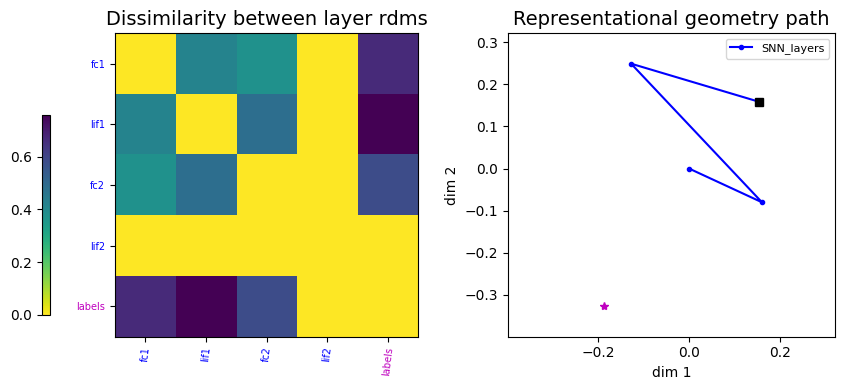

In [56]:
features = {'SNN_layers': activations_per_timestep}
model_colors = {'SNN_layers': 'b'}
rep_path(features, model_colors, labels, rdm_calc_method='correlation', rdm_comp_method='spearman')